In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import random
import itertools
import numpy as np
import pandas as pd

In [4]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
pgenes = set(pgenes[pgenes == True].index)

UWOP 4014
Y55 4190
YPS 4093
S288C 4889

total 3786


In [5]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [6]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index().reset_index()

In [7]:
res = []
for s in strains:
    x1 = d[d['strain1'] == s]
    x2 = d[d['strain2'] == s]
    x1 = x1.rename(columns={'strain1': 'strain',
                            'phenotype1': 'phenotype',
                            'strain2': 'other',
                            'phenotype2': 'otherp'}
                  ).T.sort_index().T
    x2 = x2.rename(columns={'strain2': 'strain',
                            'phenotype2': 'phenotype',
                            'strain1': 'other',
                            'phenotype1': 'otherp'}
                  ).T.sort_index().T
    x = pd.concat([x1, x2]).reindex()
    
    y = x[(x['phenotype']) | (x['otherp'])]
    
    for o in set(strains).difference([s]):
        e = y[(y['phenotype']) &
              (y['qvalue'] < 0.01) &
              (y['other'] == o)].set_index(['gene',
                                            'condition'])
        sh = y[(y['phenotype']) &
               (y['otherp']) &
               (y['qvalue'] >=  0.01) &
               (y['other'] == o)].set_index(['gene',
                                             'condition'])
        
        p = sh.shape[0] + e.shape[0]
        
        res.append((s, o,
                    2,
                    sh.shape[0]/p,
                    e.shape[0]/p))
    
    for i in [2, 3]:
        for o in itertools.combinations(set(strains).difference([s]),
                                        i):
            e = y[(y['phenotype']) &
                  (y['qvalue'] < 0.01) &
                  (y['other'].isin(o))].set_index(['gene',
                                                   'condition']).sort_index()
            sh = y[(y['phenotype']) &
                   (y['otherp']) &
                   (y['qvalue'] >=  0.01) &
                   (y['other'].isin(o))].groupby(['gene',
                                                  'condition'])['strain'].count()
            sh = sh[sh >= i]
            
            e = e.loc[e.index.difference(sh.index)]
            
            p = sh.shape[0] + e.shape[0]
        
            res.append((s, ','.join(o),
                        i+1,
                        sh.shape[0]/p,
                        e.shape[0]/p))

r = pd.DataFrame(res,
                 columns=['strain',
                          'others',
                          'comparisons',
                          'shared',
                          'exclusive'])

In [8]:
p = r.set_index(['strain',
                 'others',
                 'comparisons']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'others',
             'comparisons',
             'variable',
             'value']

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


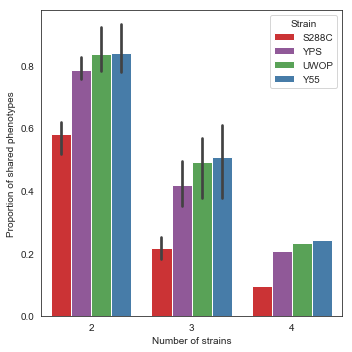

In [9]:
sns.catplot(x='comparisons', y='value',
            hue='strain',
            height=5, aspect=1,
            kind='bar', data=p[p['variable'] == 'shared'],
            hue_order=p[(p['variable'] == 'shared') &
                        (p['comparisons'] == 2)
                       ].groupby('strain')['value'].mean().sort_values().index,
            palette=[cstrains[x] for x in p[(p['variable'] == 'shared') &
                                            (p['comparisons'] == 2)
                                           ].groupby('strain')['value'
                                           ].mean().sort_values().index],
            legend=False)

plt.legend(title='Strain',
           loc='upper right')

plt.ylabel('Proportion of shared phenotypes')
plt.xlabel('Number of strains')

sns.despine(top=False,
            right=False)

plt.savefig('deviations-sets-increasing.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations-sets-increasing.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);